In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
from collections import Counter
import random

data_folder = "data"
spotify_file = "spotify_articles.csv"
spotify_path = os.path.join(data_folder, spotify_file)

census_file = "census_articles.csv"
census_path = os.path.join(data_folder, census_file)

helsinki_file = "helsinki_articles.csv"
helsinki_path = os.path.join(data_folder, helsinki_file)

In [2]:
def cleanArticle(article, sep = "###", n = 3):
    """ Given a scraped article, splits it into paragraphs by sep, and 
    removes paragraphs n words and under. Returns the article with 
    newlines between paragraphs
    """
    paras = article.split(sep)
    paras = [para for para in paras if len(para.split()) > n]
    return("\n".join(paras))

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

spotify_df = readArticles(spotify_path)
census_df = readArticles(census_path)
helsinki_df = readArticles(helsinki_path)

dict_by_ids(helsinki_df, [6])
helsinki_df.head()

,id,publisher,scrape_time,text,doc
0,6,nytimes.com,2018-07-15T07:54:28-04:00,Trump Plays Golf in Scotland Before Putin Summ...,Trump Plays Golf in Scotland Before Putin Summ...
1,35,dailymail.co.uk,2018-07-15T06:34:13-04:00,"Sunday, Jul 15th 2018 5-Day Forecast ### Adver...",None
2,57,newyorker.com,2018-07-16T09:10:56-04:00,Will Putin Spare Trump the Lecture He Has Give...,None
3,77,oregonlive.com,2018-07-16T10:19:40-04:00,Enter City and State or Zip Code ### Congratul...,None
4,106,bostonglobe.com,2018-07-16T03:33:28-04:00,The Boston Globe ### Scroll to top of page ###...,None


In [3]:
clust_levinson = [610, 3581, 6678]
clust_reuters = [761, 16223]
clust_ap = [8200, 8818, 9990]
clust_ap_files = [12769, 2313, 6190]
clust_freshair = [7042, 6644]
unique = [6754, 10053, 10250, 6146, 967, 15307, 15482, 604, 1766, 4738, 5906, 6844, 14721, 14730]
clust_wrong = [10254, 9090]
clust_snippet = [7624, 8985, 5289]
# 7624 = paraphrase of AP
# 8985 = briefing of many news stories, includes snippet from 6844
# 967 = not exactly copied from, but heavily based off of the original NYT report 
# 1766 = heavily based off of reuters 

In [4]:
ac = tc.ArticleComparisons(thresh_jaccard = .25, thresh_same_sent = .9, thresh_same_doc = .5)

doc_r1 = docs.Document(census_df[census_df["id"] == 761].iloc[0, 3], clean = False)
doc_ap1 = docs.Document(census_df[census_df["id"] == 8200].iloc[0, 3], clean = False)
doc_ap2 = docs.Document(census_df[census_df["id"] == 8818].iloc[0, 3], clean = False)
doc_w = docs.Document(census_df[census_df["id"] == 10254].iloc[0, 3], clean = False)

doc_6844 = docs.Document(census_df[census_df["id"] == 6844].iloc[0, 3], clean = False)
snip_6844 = docs.Document(census_df[census_df["id"] == 8985].iloc[0, 3], clean = False)

jac_mat_ap = ac.get_jaccard_matrix(doc_ap1, doc_ap2)
jac_mat_w = ac.get_jaccard_matrix(doc_ap1, doc_w)

In [5]:
# jac_mat_ap_r = comparer.get_jaccard_matrix(doc_r1, doc_ap1)
print("Example of a 0.4 Jaccard index:\n")
print(doc_r1.get_sentences()[1], "\n", doc_ap1.get_sentences()[4])

Example of a 0.4 Jaccard index:

 In a filing in Manhattan federal court on Thursday, the groups said that the administration hid the fact during the course of the lawsuit that went to trial last year that Thomas Hofeller, a longtime Republican specialist on drawing electoral districts, played a "significant role" in planning the citizenship question. 
  The filing in Manhattan federal court said a trove of newly discovered documents revealed that Thomas Hofeller, a longtime Republican gerrymandering guru, played a key role in pushing the Trump administration to include a citizenship question on the census for the first time since 1950.


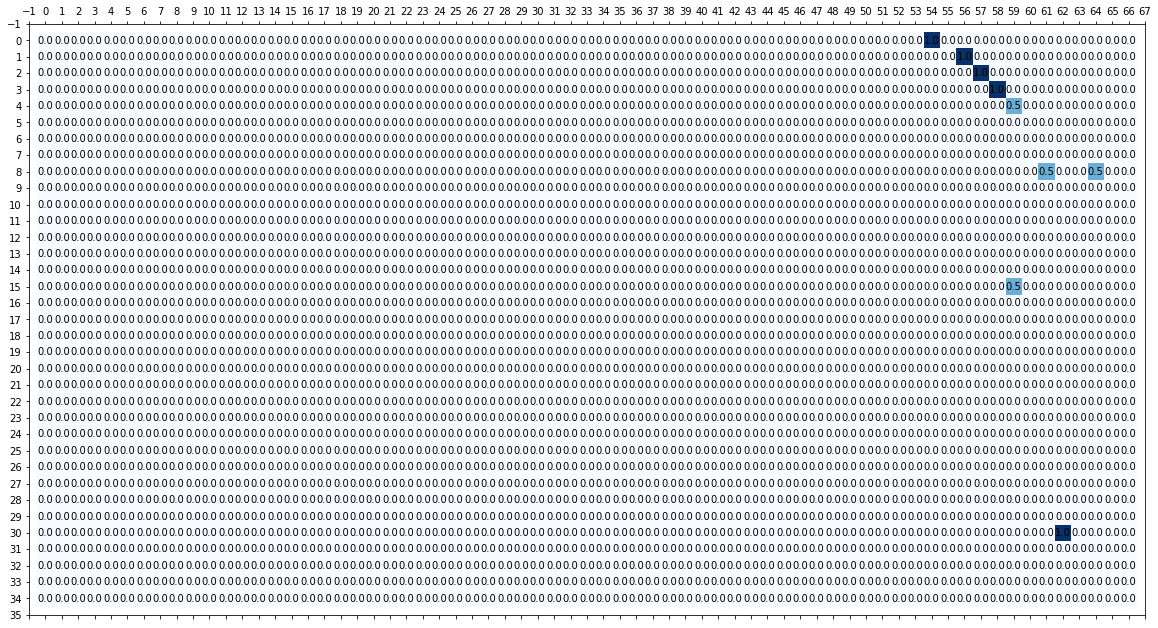

In [6]:
jac_mat_snip = ac.get_jaccard_matrix(doc_6844, snip_6844)
#ac.display_mat(jac_mat_snip)

match_mat_snip = ac.get_match_matrix(doc_6844, snip_6844)
ac.display_mat(match_mat_snip)

In [7]:
ac.print_sentence_matches()
print(ac.jaccard_score(doc_6844, snip_6844))
print(np.sum(jac_mat_snip * match_mat_snip))

S 0 :  Immigration activists rallied outside the Supreme Court in April as the justices heard arguments over the Trump administration's plan to ask about citizenship on the 2020 census.(J. 

	T 54 0.84 :  Immigration activists rally outside the Supreme Court as the justices hear arguments over the Trump administration's plan to ask about citizenship on the 2020 census, in Washington. 

S 1 : Scott Applewhite/Associated Press/File 2019) 

	T 56 0.33 : Scott Applewhite) 

S 2 :  WASHINGTON — Just weeks before the Supreme Court is expected to rule on whether the Trump administration can add a citizenship question to the 2020 census, new evidence emerged Thursday suggesting that the question was crafted specifically to give an electoral advantage to white Republicans. 

	T 57 0.72 :  BOMBSHELL DEVELOPMENT IN CENSUS CASE: "Just weeks before the Supreme Court is expected to rule on whether the Trump administration can add a citizenship question to the 2020 Census, new evidence emerged Thursd

In [8]:
bow1 = doc_6844.get_bow_sentences()[9]
bow2 = snip_6844.get_bow_sentences()[60]
ac.jaccard_index(bow1, bow2, visualize = True)

Jaccard Index: 0.21428571428571427
U: {'trump', 'the', 'administr', 'hofel', 'in', 'lawyer'}
I: {'with', 'letter', 'idea', 'furman', 'then', '2017', 'accord', 'to', 'push'} 
 {'court', 'role', 'argu', 'also', 's', 'that', 'proceed', 'obscur', 'purpos', 'offici'}


0.21428571428571427

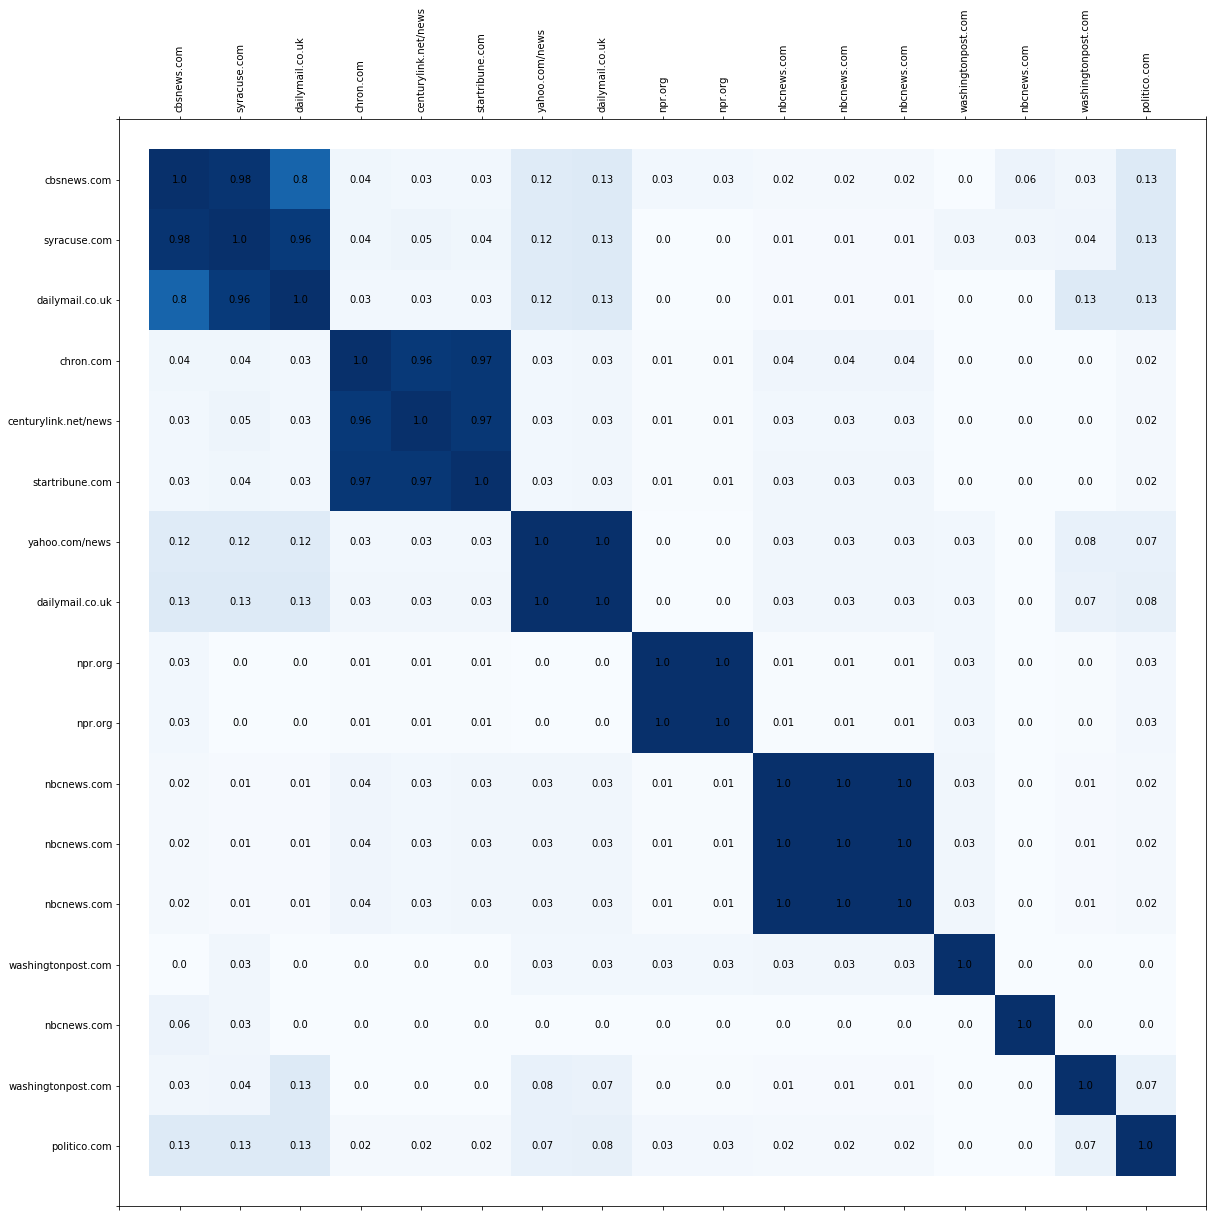

In [9]:
docs_list = clust_ap + clust_ap_files + clust_reuters + clust_freshair + clust_levinson + clust_wrong + [8985, 1766]
# 8985 = briefing of many news stories, includes snippet from 6844
# 1766 = heavily based off of reuters 
clusters_dict = dict_by_ids(census_df, docs_list)

score_mat = ac.jac_score_mat(clusters_dict, weighted = False)
axislabels = [census_df[census_df["id"] == id].iloc[0, 1] for id in docs_list]
ac.display_mat(score_mat, True, axislabels)

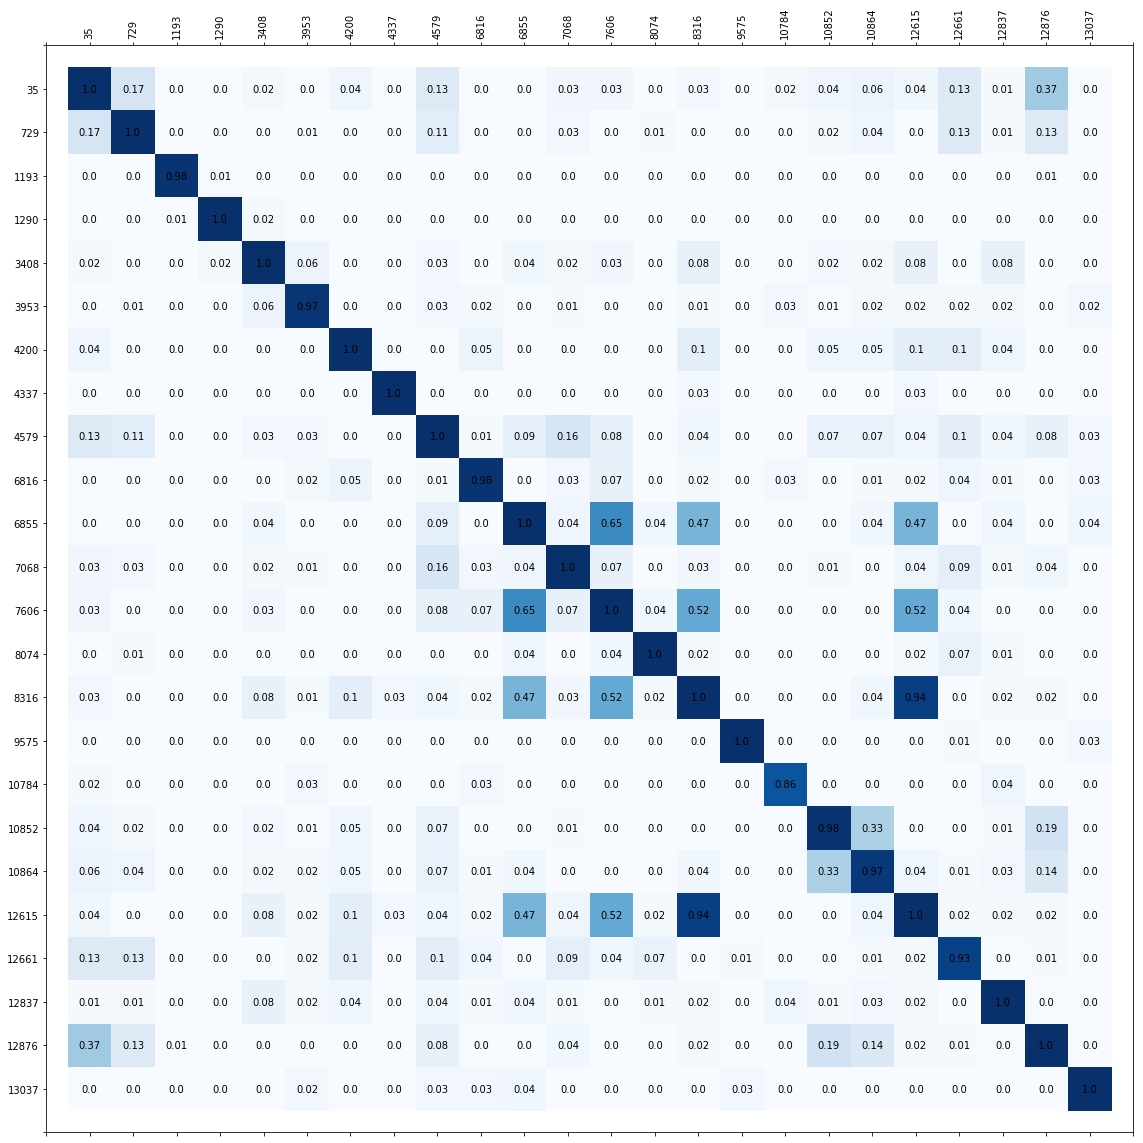

In [10]:
dm_ids = helsinki_df.loc[(helsinki_df["publisher"] == "dailymail.co.uk"), "id"]
dm_dict = dict_by_ids(helsinki_df, dm_ids)

score_mat = ac.jac_score_mat(dm_dict, weighted = False)
axislabels = list(dm_dict.keys())
ac.display_mat(score_mat, True, axislabels)

# 35, 729, and 12876 contain similar snippets as they are all news-in-summary type articles
# 6855, 7606 have a score of .61; are both very short articles sharing similar sentences 
# 6855, 8316[12615] have score .25[.29]; contains many short sentences (captions?) that are in 6855
# 8316, 12615 .86,  same article 
# 10864, 10852 have score .25, same topic, different articles but some shared sentences (esp. photo captions)

S 0 : Sunday, Jul 15th 2018 5-Day Forecast 

	T 0 1.0 : Sunday, Jul 15th 2018 5-Day Forecast 

S 3 :  The U.S. homeland security secretary says there are no signs Russia is targeting the 2018 midterm elections for cyberattacks with the "scale and scope" it used in 2016. 

	T 2 0.51 :  PHILADELPHIA (AP) - The U.S. homeland security secretary said on Saturday there are no signs that Russia is targeting this year's midterm elections with the same "scale or scope" it targeted the 2016 presidential election. 

S 4 :  U.S. Department of Homeland Security Secretary Kirstjen Nielsen addresses a convention of state secretaries of state, Saturday, July 14, 2018, in Philadelphia. 

	T 7 1.0 :  U.S. Department of Homeland Security Secretary Kirstjen Nielsen addresses a convention of state secretaries of state, Saturday, July 14, 2018, in Philadelphia. 

S 5 : Nielsen told the gathering that there are no signs that Russia is targeting this year's midterm elections with the same "scale or scope" it 

0.340238281115163

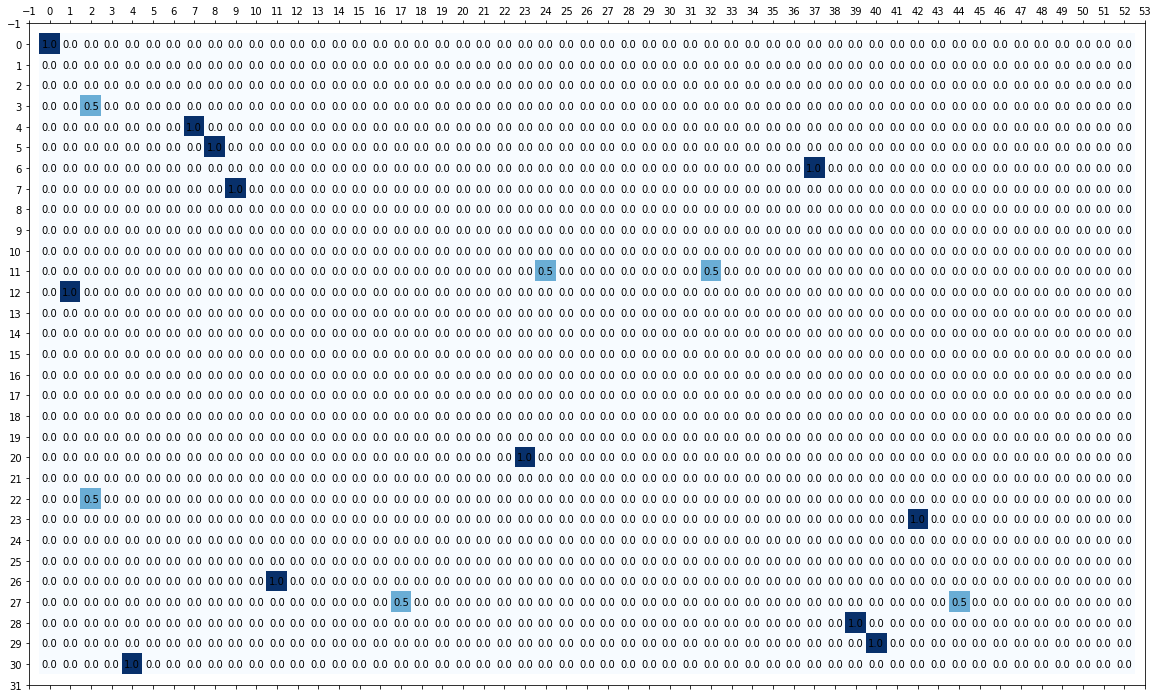

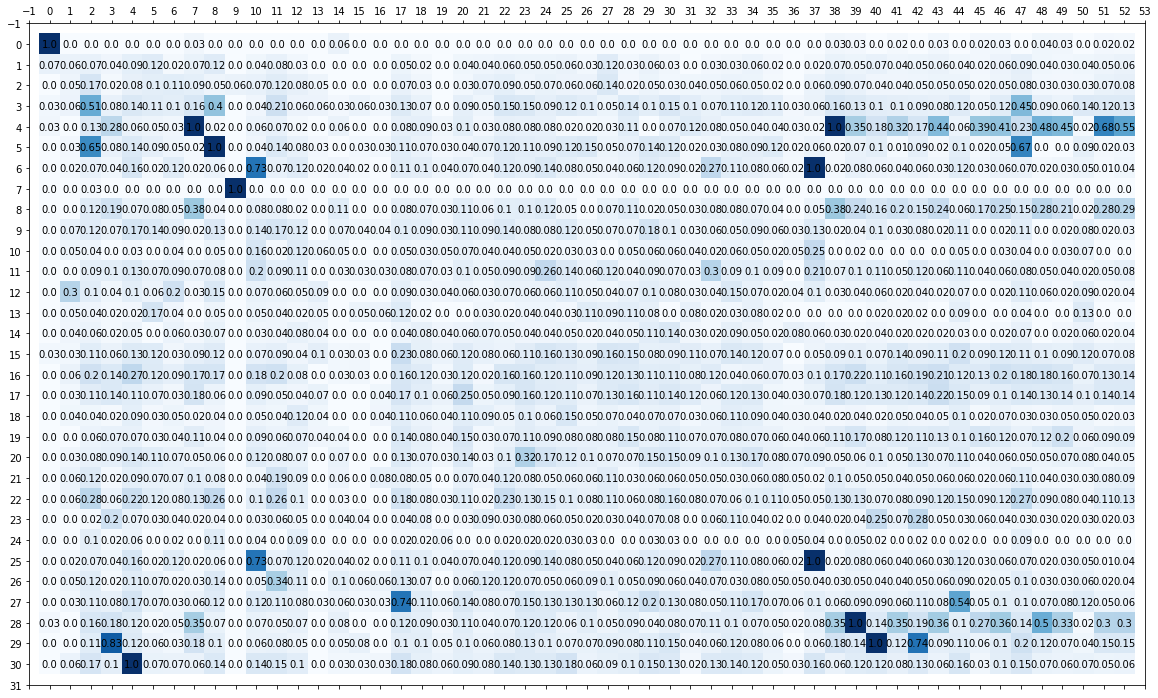

In [11]:
id1 = 10864
id2 = 10852
ac.display_mat(ac.get_match_matrix(dm_dict[id1], dm_dict[id2]))
ac.display_mat(ac.get_jaccard_matrix())
ac.print_sentence_matches()
ac.jaccard_score()

In [12]:
"""
for (i, doc) in dm_dict.items():
    print(i, "\n")
    print(doc, "\n\n")
"""

'\nfor (i, doc) in dm_dict.items():\n    print(i, "\n")\n    print(doc, "\n\n")\n'

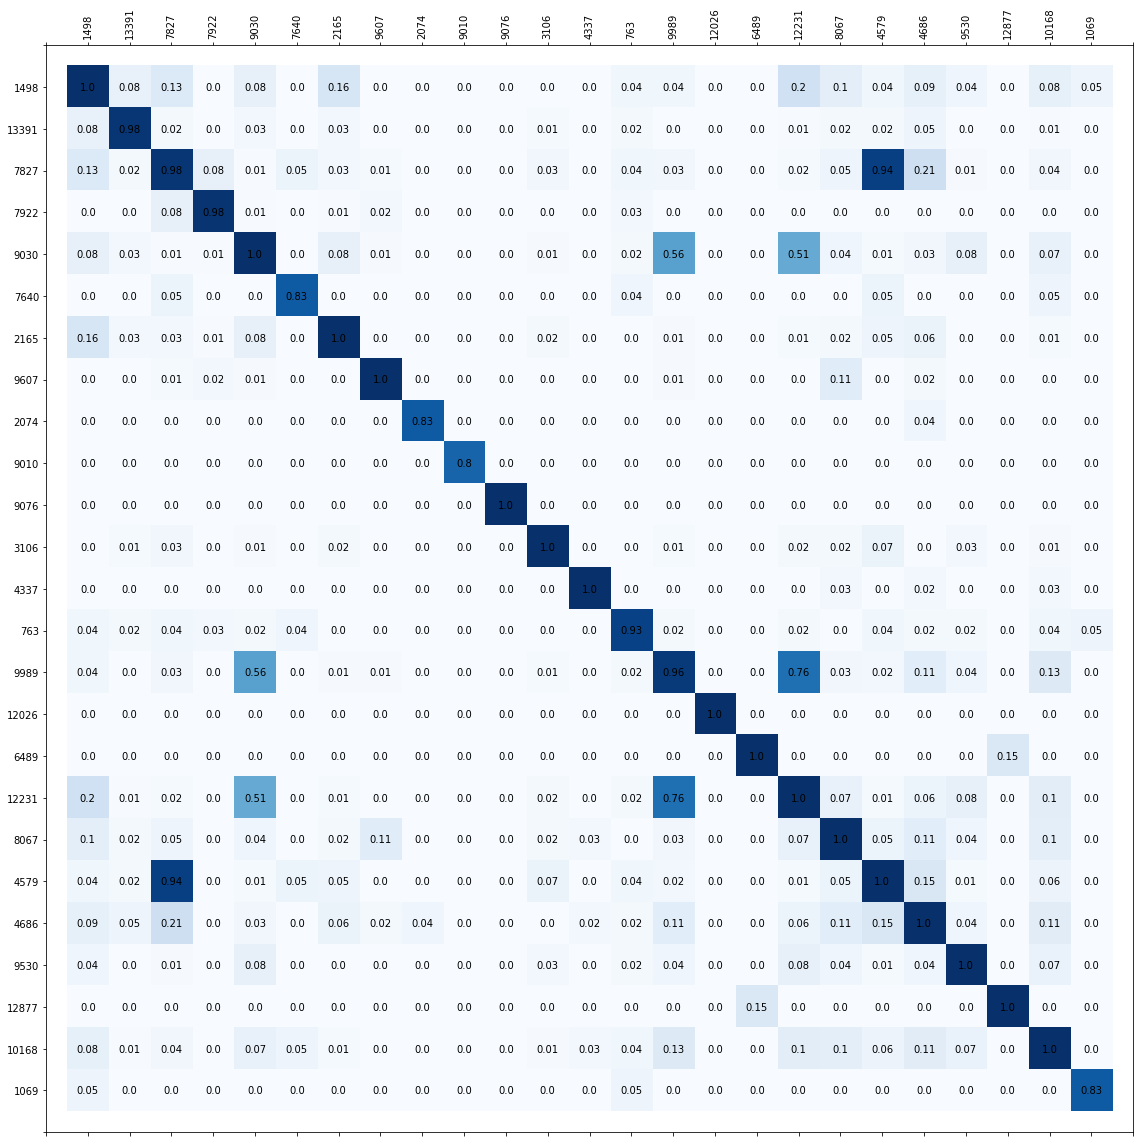

In [13]:
#rand_ids = random.sample(list(helsinki_df["id"]), 25)
rand_ids = [1498, 13391, 7827, 7922, 9030, 7640, 2165, 9607, 
            2074, 9010, 9076, 3106, 4337, 763, 9989, 12026, 6489, 
            12231, 8067, 4579, 4686, 9530, 12877, 10168, 1069]
helsinki_dict = dict_by_ids(helsinki_df, rand_ids)

score_mat = ac.jac_score_mat(helsinki_dict, weighted = False)
axislabels = list(helsinki_dict.keys())
ac.display_mat(score_mat, True, axislabels)

# articles 7827, 4579 only have an index of 0.63, but are the same article with the exception of an additional few paras
# reason: garbage text (HTML) in 7827, repeated text (esp. photo captions and quotes)
# CHANGED: deleted the constraint that sentences can only match adjacent sentences, now up to 0.65

# articles 9030, 9989, 12231 have scores in the .30s-.50
# All share copied paragraphs, but also different follow-up paragraphs 

In [14]:
'''
for (i, doc) in helsinki_dict.items():
    print(i, "\n")
    print(doc, "\n\n")
'''

'\nfor (i, doc) in helsinki_dict.items():\n    print(i, "\n")\n    print(doc, "\n\n")\n'

S 5 : But in advance of the talks, Trump listed a series of topics that did not include Russian meddling in the 2016 presidential election. 

	T 4 0.57 : Trump laid out a list of topics for discussion that notably did not include Russian meddling in the 2016 presidential election. 

S 6 :  “We have not been getting along well for the last number of years,” Trump said after arriving at the Presidential Palace in Finland’s capital, where the leaders are meeting. 

	T 5 0.64 :  "We have not been getting along well for the last number of years," Trump said as he and Putin sat down at the Presidential Palace in Finland's capital. 

S 7 : “But I think we will end up having an extraordinary relationship. 

	T 6 1.0 : "But I think we will end up having an extraordinary relationship. 

S 8 : … I really think the world wants to see us get along.” 

	T 7 1.0 : I really think the world wants to see us get along." 

S 9 :  Putin, for his part, said he and Trump have maintained regular contact throu

0.5563059320893612

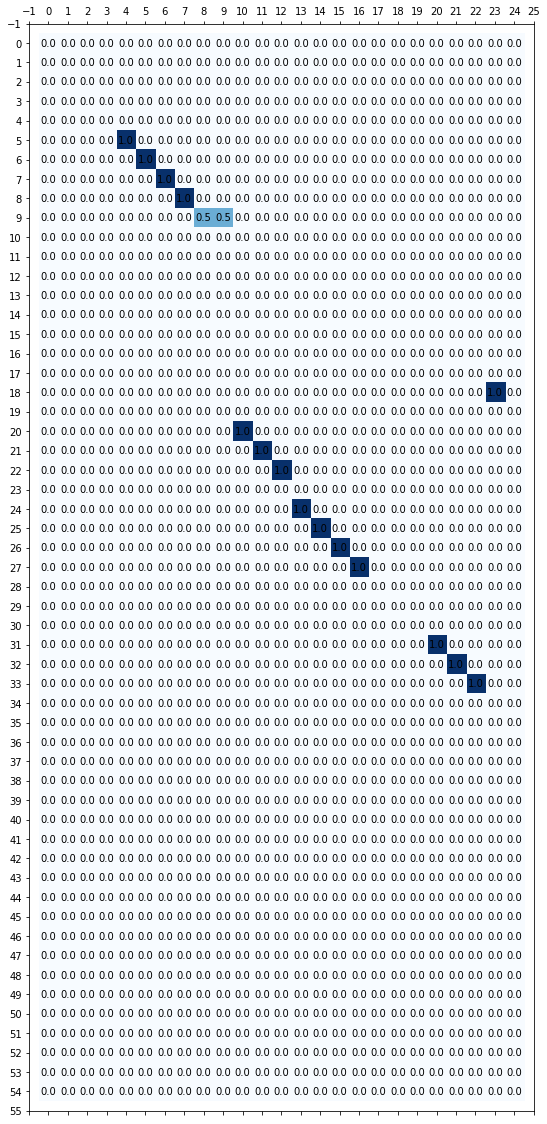

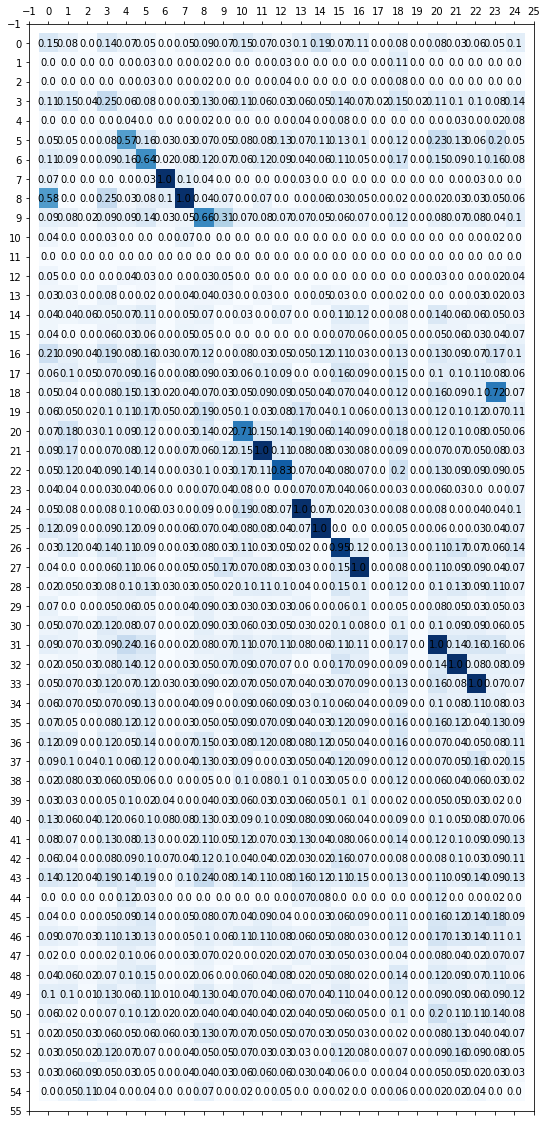

In [15]:
id1 = 9030
id2 = 9989
matchmat = ac.get_match_matrix(helsinki_dict[id1], helsinki_dict[id2], thresh_jaccard = 0.25)
ac.display_mat(matchmat)
ac.display_mat(ac.get_jaccard_matrix())

ac.print_sentence_matches()
ac.jaccard_score()